Epoch 1/50, Loss: 0.00361
Epoch 2/50, Loss: 0.00048
Epoch 3/50, Loss: 0.00032
Epoch 4/50, Loss: 0.00025
Epoch 5/50, Loss: 0.00022
Epoch 6/50, Loss: 0.00023
Epoch 7/50, Loss: 0.00018
Epoch 8/50, Loss: 0.00019
Epoch 9/50, Loss: 0.00020
Epoch 10/50, Loss: 0.00019
Epoch 11/50, Loss: 0.00016
Epoch 12/50, Loss: 0.00016
Epoch 13/50, Loss: 0.00012
Epoch 14/50, Loss: 0.00019
Epoch 15/50, Loss: 0.00012
Epoch 16/50, Loss: 0.00012
Epoch 17/50, Loss: 0.00010
Epoch 18/50, Loss: 0.00011
Epoch 19/50, Loss: 0.00010
Epoch 20/50, Loss: 0.00008
Epoch 21/50, Loss: 0.00009
Epoch 22/50, Loss: 0.00011
Epoch 23/50, Loss: 0.00010
Epoch 24/50, Loss: 0.00010
Epoch 25/50, Loss: 0.00008
Epoch 26/50, Loss: 0.00008
Epoch 27/50, Loss: 0.00009
Epoch 28/50, Loss: 0.00007
Epoch 29/50, Loss: 0.00009
Epoch 30/50, Loss: 0.00008
Epoch 31/50, Loss: 0.00007
Epoch 32/50, Loss: 0.00008
Epoch 33/50, Loss: 0.00011
Epoch 34/50, Loss: 0.00008
Epoch 35/50, Loss: 0.00006
Epoch 36/50, Loss: 0.00007
Epoch 37/50, Loss: 0.00006
Epoch 38/5

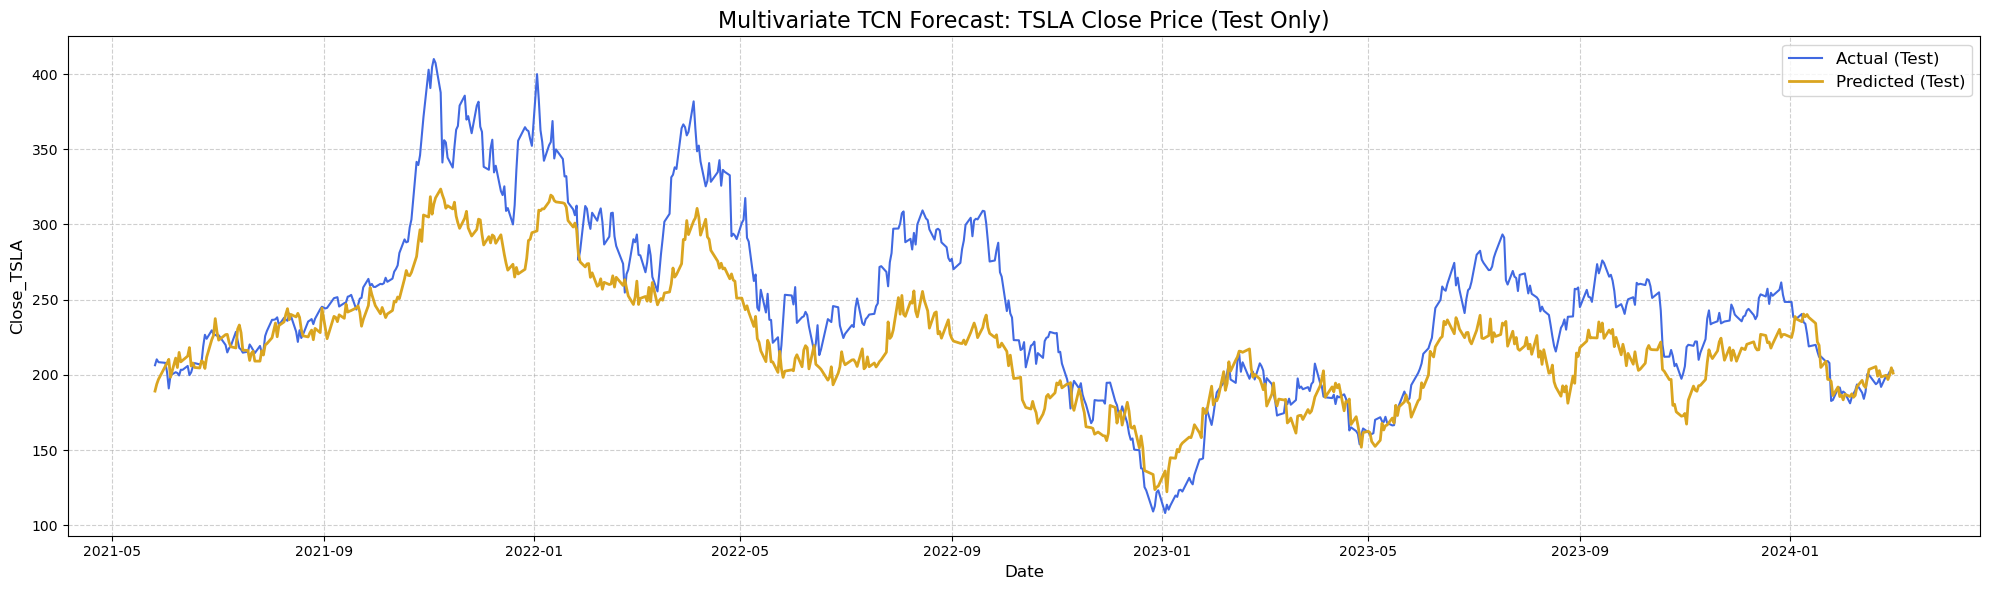


Evaluation Metrics:
RMSE      : 35.2020
MSE       : 1239.1815
MAE       : 27.9373
MAPE      : 10.64%
R² Score  : 0.6280
Adj. R²   : 0.5909


In [20]:
# ─── Imports ─────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import time
import psutil
import os

# ─── Load Dataset ────────────────────────────────────────────────────────────────
file_path = r"C:\Users\diand\OneDrive - SUNTECH S.A\Desktop\Machine Learning and Predictive Modeling\Final Assignment\Finance.csv"
df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna().sort_values('Date').reset_index(drop=True)
df = df[df['Close_TSLA'] >= 0].reset_index(drop=True)

# ─── Set Target and Features ─────────────────────────────────────────────────────
target_col = 'Close_TSLA'
exclude_cols = ['Date', target_col, 'Volume']
input_cols = df.columns.difference(exclude_cols)

# ─── Normalize ───────────────────────────────────────────────────────────────────
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[input_cols.tolist() + [target_col]])
scaled_df = pd.DataFrame(scaled, columns=input_cols.tolist() + [target_col])

# ─── Create Sequences ────────────────────────────────────────────────────────────
SEQ_LEN = 60
def create_sequences(data, target_col, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        seq_x = data.iloc[i:i+seq_len][input_cols].values
        seq_y = data.iloc[i+seq_len][target_col]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_np, y_np = create_sequences(scaled_df, target_col, SEQ_LEN)
X = torch.tensor(X_np, dtype=torch.float32).permute(0, 2, 1)  # (B, C, T)
y = torch.tensor(y_np, dtype=torch.float32)

# ─── Train-Test Split ────────────────────────────────────────────────────────────
split_idx = int(0.7 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ─── Define TCN ──────────────────────────────────────────────────────────────────
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU()
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            in_ch = input_size if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation))
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)
    def forward(self, x):
        y = self.network(x)
        return self.linear(y[:, :, -1])

# ─── Training ────────────────────────────────────────────────────────────────────
def get_memory_usage():
    return psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCN(X.shape[1], 1, [16, 32, 32, 32]).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 50
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)

start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss / len(train_loader):.5f}")

print(f"\nTraining Time: {round(time.time() - start_time, 2)} sec | Peak Memory: {round(get_memory_usage(), 2)} MB")

# ─── Prediction ──────────────────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy().squeeze()

# ─── Inverse Scale ───────────────────────────────────────────────────────────────
reconstruct = scaled_df.iloc[SEQ_LEN + split_idx:].copy().reset_index(drop=True)
reconstruct = reconstruct.iloc[:len(test_preds)].copy()
reconstruct[target_col] = test_preds
inv_scaled = scaler.inverse_transform(reconstruct)
predicted_vals = inv_scaled[:, reconstruct.columns.get_loc(target_col)]

actual_vals = df[target_col].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values
forecast_dates = df['Date'].iloc[SEQ_LEN + split_idx:][:len(predicted_vals)].values

# ─── Plot Test Forecast Only (Styled) ────────────────────────────────────────────
plt.figure(figsize=(20, 6))
plt.plot(forecast_dates, actual_vals, label='Actual (Test)', color='royalblue', linewidth=1.5)
plt.plot(forecast_dates, predicted_vals, label='Predicted (Test)', color='goldenrod', linewidth=2)
plt.title('Multivariate TCN Forecast: TSLA Close Price (Test Only)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close_TSLA', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# ─── Metrics ─────────────────────────────────────────────────────────────────────
mse = mean_squared_error(actual_vals, predicted_vals)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_vals, predicted_vals)
mape = np.mean(np.abs((actual_vals - predicted_vals) / actual_vals)) * 100
r2 = r2_score(actual_vals, predicted_vals)
n, k = len(actual_vals), X.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print("\nEvaluation Metrics:")
print(f"RMSE      : {rmse:.4f}")
print(f"MSE       : {mse:.4f}")
print(f"MAE       : {mae:.4f}")
print(f"MAPE      : {mape:.2f}%")
print(f"R² Score  : {r2:.4f}")
print(f"Adj. R²   : {adj_r2:.4f}")
